In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
print('NetworkX version: {}'.format(nx.__version__))

NetworkX version: 2.4


![](simple_network.JPG)

In [2]:
G=nx.DiGraph()
G.add_node('A', role = 'source')
G.add_node('F', role = 'target')

G.add_edge('A','B', weight = 1 ) # Directed edge From A to B
G.add_edge('A','C', weight = 7)
G.add_edge('B','D', weight = 2)
G.add_edge('C','D', weight = 8)
G.add_edge('D','E', weight = 9)
G.add_edge('C','F', weight = 15)
G.add_edge('D','F', weight = 1)
G.add_edge('E','F', weight = 3)

In [3]:
sp = nx.shortest_path(G,'A', 'F', 'weight')
list(zip(sp[:-1],sp[1:]))

[('A', 'B'), ('B', 'D'), ('D', 'F')]

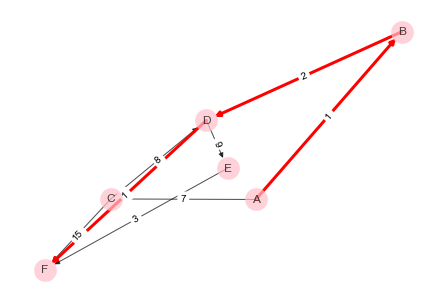

In [4]:
pos_fr = nx.fruchterman_reingold_layout(G)
pos_fr

nx.draw(G, pos=pos_fr, node_size=500, 
        alpha = 0.7, node_color='pink', 
        with_labels=True)

# Plot edges 
nx.draw_networkx_edges(G, pos=pos_fr, edgelist=list(zip(sp[:-1],sp[1:])), width=3, edge_color='red')

# Plot edge labels
nx.draw_networkx_edge_labels(G, pos=pos_fr, edge_labels=nx.get_edge_attributes(G,'weight'))
plt.tight_layout()

In [5]:
# initial pheromone values

nx.set_edge_attributes(G, 0, 'pheromone')
G.edges(data =True)

OutEdgeDataView([('A', 'B', {'weight': 1, 'pheromone': 0}), ('A', 'C', {'weight': 7, 'pheromone': 0}), ('B', 'D', {'weight': 2, 'pheromone': 0}), ('C', 'D', {'weight': 8, 'pheromone': 0}), ('C', 'F', {'weight': 15, 'pheromone': 0}), ('D', 'E', {'weight': 9, 'pheromone': 0}), ('D', 'F', {'weight': 1, 'pheromone': 0}), ('E', 'F', {'weight': 3, 'pheromone': 0})])

In [6]:
phe = nx.get_edge_attributes(G, 'pheromone')
phe

{('A', 'B'): 0,
 ('A', 'C'): 0,
 ('B', 'D'): 0,
 ('C', 'D'): 0,
 ('C', 'F'): 0,
 ('D', 'E'): 0,
 ('D', 'F'): 0,
 ('E', 'F'): 0}

In [7]:
new_phe = {k:v+1 for k, v in phe.items()}
new_phe

{('A', 'B'): 1,
 ('A', 'C'): 1,
 ('B', 'D'): 1,
 ('C', 'D'): 1,
 ('C', 'F'): 1,
 ('D', 'E'): 1,
 ('D', 'F'): 1,
 ('E', 'F'): 1}

In [8]:
nx.set_edge_attributes(G, new_phe, 'pheromone')
phe = nx.get_edge_attributes(G, 'pheromone')
phe

{('A', 'B'): 1,
 ('A', 'C'): 1,
 ('B', 'D'): 1,
 ('C', 'D'): 1,
 ('C', 'F'): 1,
 ('D', 'E'): 1,
 ('D', 'F'): 1,
 ('E', 'F'): 1}

In [9]:
G.edges[('A', 'B')]

{'pheromone': 1, 'weight': 1}

In [10]:
G.edges[('A', 'B')]['pheromone']

1

In [11]:
list(nx.all_neighbors(G, 'A'))

['B', 'C']

In [12]:
G.edges(['A'])

OutEdgeDataView([('A', 'B'), ('A', 'C')])

In [13]:
[(e, G.edges[e]['weight']) for e in G.edges(['A'])]

[(('A', 'B'), 1), (('A', 'C'), 7)]

In [14]:
possible_cities = [e[1] for e in G.edges(['A'])]
possible_cities

['B', 'C']

In [15]:
pheromones = [G.edges[e]['pheromone'] for e in G.edges(['A'])]
pheromones

[1, 1]

In [16]:
distances = [G.edges[e]['weight'] for e in G.edges(['A'])]
distances

[1, 7]

# Ant Colony

In [17]:
class ant():
    def __init__(self, G, start = 'A', end = 'E',
                alpha = 1, beta = 1):
        
        self.G = G
        self.current_city = start
        self.target_city = end
        self.alpha, self.beta = alpha, beta
        self.route = [self.current_city]
    
    def move(self):
        """
        Move one step
        """
        if self.current_city == self.target_city:
            return
        
        # non-zero distances
        self.possible_cities = [e[1] for e in G.edges([self.current_city])]
        
        # Dont visit an-already-visited city
        for city in self.route:
            if city in self.possible_cities:
                self.possible_cities.remove(city)
        
        distances = np.array([G.edges[e]['weight'] for e in G.edges([self.current_city])])
        pheremons = np.array([G.edges[e]['pheromone'] for e in G.edges([self.current_city])])
        
        preferences = pheremons**self.alpha/distances**self.beta
        probabilities = preferences/preferences.sum()
        #print("distances", distances)
        #print("pheremons", pheremons)
        #print(probabilities)
        
        self.current_city = np.random.choice(a = self.possible_cities, 
                                             size=1, 
                                             p = probabilities)[0]
        
        self.route.append(self.current_city) 
        #self.possible_cities.remove(self.current_city)
        
    def go(self):
        """
        Bulid route/path
        """
        for i in range(self.G.number_of_nodes()):
            self.move()

    def deposit(self):
        return self.route
    

In [18]:
class antcolony():
    def __init__(self, G):
        
        self.G = G
        self.true_path = nx.shortest_path(G,'A', 'F', 'weight')
        self.start, self.end = self.true_path[0], self.true_path[-1]
        
        # initial pheromone values
        nx.set_edge_attributes(self.G, 0.1, 'pheromone')
        
        self.true_path_ratio = []

    def evaporation(self, decay = 0.05):
        # Evaporation of Pheromon
        phe = nx.get_edge_attributes(G, 'pheromone')
        new_phe = {k:v * (1 - decay) for k, v in phe.items()}
        nx.set_edge_attributes(self.G, new_phe, 'pheromone')

        
    def deposit(self, route, delta = 1):
        for i,j in zip(route[:-1], route[1:]):
            self.G.edges[(i, j)]['pheromone'] +=  delta/ self.G.edges[(i, j)]['weight']
            #self.phe.loc[i, j] +=  delta/self.env.loc[i, j]
        
    def run(self, K = 10, time = 20):
        # in each time step
        for t in range(time):
            # K ants exist in the colony
            self.colony = [ant(self.G, start= self.start,end =  self.end) 
                      for k in range(K)]

            # distributed and paralel moves of K ants
            for k in range(K):
                self.colony[k].go()   

            # after independent moves, ants deposit pheremon
            for k in range(K):
                path = self.colony[k].deposit()
                self.deposit(route = path)
                
            self.evaporation()
            
            self.true_path_ratio.append(np.mean([a.route == self.true_path for a in self.colony]))

In [19]:
swarm = antcolony(G)
swarm.run(K = 10, time = 10)

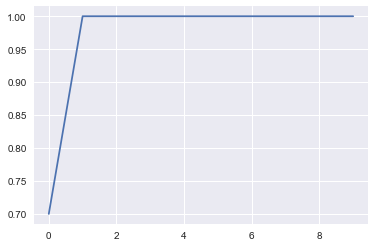

In [20]:
plt.plot(swarm.true_path_ratio)
plt.show()

In [21]:
[a.route for a in swarm.colony]

[['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F']]

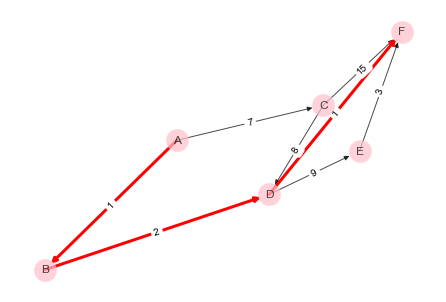

In [22]:
sp = swarm.colony[0].route

pos_fr = nx.fruchterman_reingold_layout(G)
pos_fr

nx.draw(G, pos=pos_fr, node_size=500, 
        alpha = 0.7, node_color='pink', 
        with_labels=True)

# Plot edges 
nx.draw_networkx_edges(G, pos=pos_fr, edgelist=list(zip(sp[:-1],sp[1:])), width=3, edge_color='red')

# Plot edge labels
nx.draw_networkx_edge_labels(G, pos=pos_fr, edge_labels=nx.get_edge_attributes(G,'weight'))
plt.tight_layout()